### 🚧 Crossroads Detection from OSM Roads
This notebook outlines a step-by-step geospatial processing workflow to extract and clean crossroad locations from OpenStreetMap (OSM) road data. The result will be a set of snapped centroid points representing the main intersections within a study area.

##### 🗺️ 1. Workflow Overview
- Download OSM roads

- Clip to research area (if needed, not shown in code)

- Remove minor paths
(e.g. <code>footway</code>, <code>track</code>, <code>service</code>, etc.)

- Dissolve by road name
Combines road segments with the same name into a single geometry.

- Merge multipart lines

- Detect intersections
Using spatial indexing to efficiently find intersections between lines.

- Buffer intersections by 17 meters

- Dissolve buffers to merge close points

- Convert multipart geometries to singlepart

- Calculate centroids of buffer zones

- Snap centroids to the nearest original intersection point

Roads from [Geofabrik OSM extracts – Utrecht](https://download.geofabrik.de/europe/netherlands.html)

#### 🧰 1.1 Load Required Libraries

In [2]:
import geopandas as gpd
from shapely.ops import linemerge
from shapely.geometry import Point, MultiLineString, LineString, Polygon
from rtree import index
import os

#### 📍 1.2 Load and Preprocess OSM Roads
📁 Load the road shapefile<br/>
🚫 Remove minor road types<br/>
🔀 Dissolve by name<br/>
🔁 Convert MultiLineStrings to single lines<br/>
❌ Line intersections: Find crossroads<br/>

                            geometry
11166  POINT (182946.637 581234.675)
2866   POINT (201273.265 586626.222)
1725   POINT (201984.252 568330.169)
2315   POINT (180061.402 579958.143)
23709  POINT (191829.568 551944.588)
25561  POINT (183123.398 575077.775)
15817   POINT (165284.73 578998.326)
11575  POINT (204791.122 557781.461)
6746     POINT (196764.7 544080.649)
10484  POINT (189536.264 584957.016)


<Axes: >

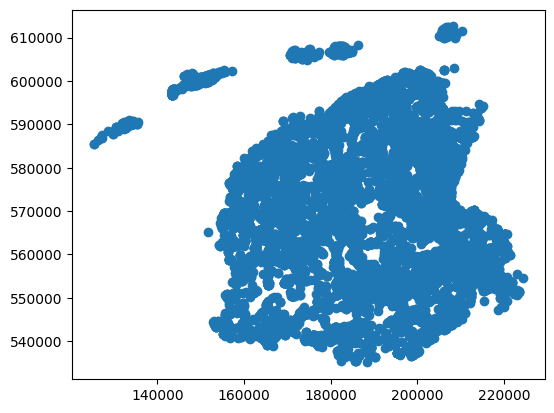

In [3]:

def merge_multilinestring(geometry):
    if isinstance(geometry, MultiLineString):
        merged = linemerge(geometry)
        return merged
    return geometry

area_name = 'Friesland'
coord_system = 28992

OSM_streets_file = fr"sources/osm_roads_{area_name}/gis_osm_roads_free_1.shp"
output_file = fr"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"

# Download and open OSM roads
streets_gdf = gpd.read_file(OSM_streets_file)
streets_gdf = streets_gdf.to_crs(epsg=28992)

# Remove small paths
rm_path_types_list = ["bridleway", "busway", "footway", "motorway", "path", "pedestrian", "path", "service", "steps", "track", "track_grade1", "track_grade2", "track_grade3", "track_grade 4"]
streets_filtered_gdf = streets_gdf[~streets_gdf["fclass"].isin(rm_path_types_list)]

# Dissolve seperate parts of street to one
streets_filtered_gdf = streets_filtered_gdf.dissolve('name')

# Multilinestring to singlepart
streets_filtered_gdf["geometry"] = streets_filtered_gdf["geometry"].apply(merge_multilinestring)

# Do an intersection on itself. Create spatial index to make complexity O(n log n) instead of O(n^2)
streets_filtered_sp_index = index.Index()
for i, geom in enumerate(streets_filtered_gdf.geometry):
    streets_filtered_sp_index.insert(i, geom.bounds)

intersection_points = []

# Check only nearby lines using the spatial index
for i, line1 in enumerate(streets_filtered_gdf.geometry):
    possible_matches = list(streets_filtered_sp_index.intersection(line1.bounds))  # Get nearby lines
    for j in possible_matches:
        if i >= j:  # Avoid duplicate and self-comparison
            continue

        line2 = streets_filtered_gdf.geometry.iloc[j]
        intersection = line1.intersection(line2)

        # Store only Point intersections
        if intersection.geom_type == "Point":
            intersection_points.append(intersection)
        elif intersection.geom_type == "MultiPoint":
            intersection_points.extend(intersection.geoms)

# Convert to a list to GeoDataFrame
crossroads_gdf = gpd.GeoDataFrame(geometry=intersection_points, crs=streets_filtered_gdf.crs)

# First check if output is generated
print(crossroads_gdf.sample(10))
crossroads_gdf.plot()

#### 🧼 1.3 Clean and Merge Crossroads
Merge intersections that are close together into one unified crossroad point using a buffer.

In [5]:
# Copy dataframe for making buffer
crossroads_buffer_gdf = crossroads_gdf
buffersize = 17
crossroads_buffer_gdf['geometry'] = crossroads_buffer_gdf["geometry"].buffer(buffersize, resolution=5)

crossroads_buffer_geoseries = crossroads_buffer_gdf.union_all()
crossroads_buffer_explode_gdf = gpd.GeoDataFrame(geometry=[crossroads_buffer_geoseries], crs=crossroads_buffer_gdf.crs).explode(index_parts=False)
crossroads_buffer_explode_gdf = crossroads_buffer_explode_gdf.reset_index(drop=True)
crossroads_buffer_explode_gdf.to_file(output_file, layer="buffer", driver="GPKG")

# Copy dataframe for centroids
crossroads_buffer_centroids_geoseries = crossroads_buffer_explode_gdf['geometry'].centroid

crossroads_buffer_centroids_gdf = gpd.GeoDataFrame(geometry=crossroads_buffer_centroids_geoseries, crs=crossroads_buffer_gdf.crs)

#### 🎯 1.4 Generate and Snap Centroids
Calculate centroids of each buffer area, then snap them to the closest actual intersection point.

⚠️ Note: Snapping method is only efficient for smaller areas (e.g. towns or cities). For large datasets, consider using spatial join methods.

In [ ]:
from shapely.geometry import Point
from shapely.ops import nearest_points

# Example of snapping points to the closest geometry in another GeoDataFrame
crossroads_buffer_centroids_gdf['geometry'] = crossroads_buffer_centroids_gdf['geometry'].apply(
    lambda x: nearest_points(x, crossroads_gdf.geometry.union_all())[1]
)

#### 💾 1.5 Save Final Output

In [7]:
if os.path.exists(output_file):
    os.remove(output_file)

crossroads_buffer_centroids_gdf.to_file(output_file, layer="crossroads", driver="GPKG")